In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import sys
import PIL as pil
from sklearn import metrics, preprocessing
import scipy.integrate
import scipy.special
import cv2
import shap
import lime
from skimage.segmentation import mark_boundaries
from imblearn import over_sampling
from imblearn.keras import balanced_batch_generator
from sklearn.utils import class_weight

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_dir = os.path.join('dataset', 'images', 'train_8')
test_dir = os.path.join('dataset', 'images', 'test_8')

In [15]:
img_height = 224
img_width = 224
num_classes = 8
batch_size = 16
#Classes = ['neutral', 'happy', 'sad', 'surprised', 'fear', 'disgusted', 'angry', 'contempt']
Classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

In [16]:
preprocessing_func = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  rescale=1./255,
                                  validation_split=0.3,
                                  preprocessing_function=preprocessing_func)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.3,
                                 preprocessing_function=preprocessing_func)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 19500 images belonging to 8 classes.
Found 8352 images belonging to 8 classes.
Found 3150 images belonging to 8 classes.


In [8]:
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(train_generator.classes), 
                                                  y=train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

In [9]:
inception_resnet_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                                                                    weights='imagenet',
                                                                                    input_shape=(img_height, img_width, 3))

inception_resnet_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

 batch_normalization_5 (BatchNo  (None, 25, 25, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 25, 25, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 25, 25, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 25, 25, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 25, 25, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 25, 25, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 25, 25, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 25, 25, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 25, 25, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 25, 25, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 25, 25, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 12, 12, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 12, 12, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 12, 12, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 12, 12, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 12, 12, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 12, 12, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 12, 12, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 12, 12, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 12, 12, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 12, 12, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 12, 12, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 12, 12, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 12, 12, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 12, 12, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 12, 12, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 5, 5, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 5, 5, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 5, 5, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 5, 5, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 5, 5, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [17]:
resnet_50 = tf.keras.applications.ResNet50(weights = 'imagenet',
                                          input_shape = (img_height, img_width, 3))

resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [31]:
efficient = tf.keras.applications.EfficientNetV2S(include_top=False, weights = 'imagenet', input_shape=(img_height, img_width, 3))

82420632/82420632 [==============================] - 24s 0us/step


In [32]:
efficient.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_9[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                   

 block2c_expand_activation (Act  (None, 56, 56, 192)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 56, 56, 48)   9216        ['block2c_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_drop (Dropout)         (None, 56, 56, 48)   0           ['block2c_project_bn[0][0]']     
          

                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 28, 28, 256)  147456      ['block3c_add[0][0]']            
                                                                                                  
 block3d_expand_bn (BatchNormal  (None, 28, 28, 256)  1024       ['block3d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3d_expand_activation (Act  (None, 28, 28, 256)  0          ['block3d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3d_p

                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 128)  65536       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 128)  512        ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (Dropout)         (None, 14, 14, 128)  0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 14, 14, 128)  0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
          

                                                                                                  
 block4d_drop (Dropout)         (None, 14, 14, 128)  0           ['block4d_project_bn[0][0]']     
                                                                                                  
 block4d_add (Add)              (None, 14, 14, 128)  0           ['block4d_drop[0][0]',           
                                                                  'block4c_add[0][0]']            
                                                                                                  
 block4e_expand_conv (Conv2D)   (None, 14, 14, 512)  65536       ['block4d_add[0][0]']            
                                                                                                  
 block4e_expand_bn (BatchNormal  (None, 14, 14, 512)  2048       ['block4e_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 768)  98304       ['block4f_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 14, 14, 768)  3072       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 14, 14, 768)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv2 (DepthwiseConv  (None, 14, 14, 768)  6912       ['block5a_expand_activation[0][0]
 2D)      

 2D)                                                             ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 14, 14, 960)  0          ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 960)         0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5e_activation (Activation  (None, 14, 14, 960)  0          ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 960)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5e_se_reshape[0][0]']     
                                                                                                  
 block5e_s

                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5g_se_reshape[0][0]']     
                                                                                                  
 block5g_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5g_se_reduce[0][0]']      
                                                                                                  
 block5g_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block5g_activation[0][0]',     
                                                                  'block5g_se_expand[0][0]']      
                                                                                                  
 block5g_p

 block5i_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5i_se_reduce[0][0]']      
                                                                                                  
 block5i_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block5i_activation[0][0]',     
                                                                  'block5i_se_expand[0][0]']      
                                                                                                  
 block5i_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block5i_se_excite[0][0]']      
                                                                                                  
 block5i_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block5i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5i_d

 block6b_drop (Dropout)         (None, 7, 7, 256)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 256)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1536)   393216      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1536)  6144        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_e

 block6e_expand_conv (Conv2D)   (None, 7, 7, 1536)   393216      ['block6d_add[0][0]']            
                                                                                                  
 block6e_expand_bn (BatchNormal  (None, 7, 7, 1536)  6144        ['block6e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6e_expand_activation (Act  (None, 7, 7, 1536)  0           ['block6e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6e_dwconv2 (DepthwiseConv  (None, 7, 7, 1536)  13824       ['block6e_expand_activation[0][0]
 2D)                                                             ']                               
          

 block6g_expand_activation (Act  (None, 7, 7, 1536)  0           ['block6g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6g_dwconv2 (DepthwiseConv  (None, 7, 7, 1536)  13824       ['block6g_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6g_bn (BatchNormalization  (None, 7, 7, 1536)  6144        ['block6g_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6g_activation (Activation  (None, 7, 7, 1536)  0           ['block6g_bn[0][0]']             
 )        

                                                                                                  
 block6i_bn (BatchNormalization  (None, 7, 7, 1536)  6144        ['block6i_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6i_activation (Activation  (None, 7, 7, 1536)  0           ['block6i_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6i_se_squeeze (GlobalAver  (None, 1536)        0           ['block6i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6i_s

 )                                                                                                
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 1536)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6k_se_squeeze[0][0]']     
                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6k_se_reduce[0][0]']      
          

 block6m_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6m_se_squeeze[0][0]']     
                                                                                                  
 block6m_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6m_se_reshape[0][0]']     
                                                                                                  
 block6m_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6m_se_reduce[0][0]']      
                                                                                                  
 block6m_se_excite (Multiply)   (None, 7, 7, 1536)   0           ['block6m_activation[0][0]',     
                                                                  'block6m_se_expand[0][0]']      
                                                                                                  
 block6m_project_conv (Conv2D)  (None, 7, 7, 256)    393216      ['block6m_se_excite[0][0]']      
          

                                                                                                  
 block6o_se_excite (Multiply)   (None, 7, 7, 1536)   0           ['block6o_activation[0][0]',     
                                                                  'block6o_se_expand[0][0]']      
                                                                                                  
 block6o_project_conv (Conv2D)  (None, 7, 7, 256)    393216      ['block6o_se_excite[0][0]']      
                                                                                                  
 block6o_project_bn (BatchNorma  (None, 7, 7, 256)   1024        ['block6o_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6o_drop (Dropout)         (None, 7, 7, 256)    0           ['block6o_project_bn[0][0]']     
          

In [122]:
mobileNet = tf.keras.applications.MobileNetV2(include_top=False, weights = 'imagenet', input_shape=(img_height, img_width, 3))
mobileNet.summary()

9406464/9406464 [==============================] - 3s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

In [10]:
def classifier(inputs):
    
    #x = tf.keras.layers.Flatten()(inputs)
    #x = tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    #x = tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    #x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    
    return x

def define_model(trained_model):
    
    inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    intermediate = trained_model(inputs)
    classification_output = classifier(intermediate)
    
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                               loss=tf.keras.losses.categorical_crossentropy,
                               metrics = ['accuracy'])
    
    return model
    

In [12]:
ires_model = define_model(inception_resnet_model)

#efficient_model.layers[1].trainable = False

ires_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056  

In [22]:
ires_model.layers[1].trainable = False

ires_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056  

In [23]:
eff_checkpoint_path = os.path.join('training', 'try\ ')
eff_callback = tf.keras.callbacks.ModelCheckpoint(filepath=eff_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

e_history = ires_model.fit_generator(train_generator, validation_data = validation_generator, callbacks = [eff_callback],
                                     epochs=20, class_weight=train_class_weights)

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
1219/1219 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8881
Epoch 1: saving model to training\try\ 
1219/1219 [==============================] - 294s 241ms/step - loss: 0.3920 - accuracy: 0.8881 - val_loss: 1.0637 - val_accuracy: 0.7261
Epoch 2/20
1219/1219 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8916
Epoch 2: saving model to training\try\ 
1219/1219 [==============================] - 295s 242ms/step - loss: 0.3860 - accuracy: 0.8916 - val_loss: 1.0867 - val_accuracy: 0.7259
Epoch 3/20
1219/1219 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8918
Epoch 3: saving model to training\try\ 
1219/1219 [==============================] - 295s 242ms/step - loss: 0.3811 - accuracy: 0.8918 - val_loss: 1.0593 - val_accuracy: 0.7259
Epoch 4/20
1219/1219 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8932
Epoch 4: saving model to training\try\ 
1219/1219 [==========================

KeyboardInterrupt: 

In [19]:
ires_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9),
                               loss=tf.keras.losses.categorical_crossentropy,
                               metrics = ['accuracy'])

In [127]:
eff_checkpoint_path = os.path.join('training', 'try\ ')
eff_callback = tf.keras.callbacks.ModelCheckpoint(filepath=eff_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

e_history = mobileNet_model.fit(x = train_generator, validation_data = validation_generator, callbacks = [eff_callback],
                                 epochs=50)

e_history = pd.DataFrame(e_history.history)

Epoch 1/50
1643/1643 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.7760
Epoch 1: saving model to training\VGG16\ 
1643/1643 [==============================] - 199s 121ms/step - loss: 0.6422 - accuracy: 0.7760 - val_loss: 1.5952 - val_accuracy: 0.5328
Epoch 2/50
   6/1643 [..............................] - ETA: 3:04 - loss: 0.4799 - accuracy: 0.8542

KeyboardInterrupt: 

In [103]:
history = resnet.fit(x = train_generator, validation_data = validation_generator, callbacks = [eff_callback],
                                 epochs=50)

Epoch 1/50
1643/1643 [==============================] - ETA: 0s - loss: 1.2521 - accuracy: 0.5806
Epoch 1: saving model to training\VGG16\ 
1643/1643 [==============================] - 209s 127ms/step - loss: 1.2521 - accuracy: 0.5806 - val_loss: 1.4921 - val_accuracy: 0.5024
Epoch 2/50
1643/1643 [==============================] - ETA: 0s - loss: 1.2482 - accuracy: 0.5771
Epoch 2: saving model to training\VGG16\ 
1643/1643 [==============================] - 215s 131ms/step - loss: 1.2482 - accuracy: 0.5771 - val_loss: 1.4931 - val_accuracy: 0.5044
Epoch 3/50
 727/1643 [============>.................] - ETA: 1:36 - loss: 1.2424 - accuracy: 0.5849

KeyboardInterrupt: 

In [ ]:
denseNet.layers[1].trainable = True

denseNet.compile(optimizer = tf.keras.optimizers.SGD(0.01),
                loss = tf.keras.losses.categorical_crossentropy,
                metrics = ['accuracy'])

d_history_ = denseNet.fit(x = train_generator, validation_data= validation_generator, epochs= 20)

d_history = d_history.append(pd.DataFrame.append(d_history_.history), ignore_index = True)

In [14]:
i_res_checkpoint_path = os.path.join('training', 'AlexNet\ ')
i_res_callback = tf.keras.callbacks.ModelCheckpoint(filepath=i_res_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

resnet.load_weights(i_res_checkpoint_path)

ValueError: Received incompatible tensor with shape (48,) when attempting to restore variable with shape (96,) and name layer_with_weights-0/bias/.ATTRIBUTES/VARIABLE_VALUE.

In [46]:
d_history = d_history.append(pd.DataFrame(d_history_.history), ignore_index = True)

C:\Users\mkbha\AppData\Local\Temp\ipykernel_7352\2850680369.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_history = d_history.append(pd.DataFrame(d_history_.history), ignore_index = True)


In [15]:
resnet = tf.keras.models.load_model(os.path.join('trained_models', 'Facial_Emotion_Inception_Resnet_V2(1).h5'))

In [24]:
ires_model.evaluate(test_generator)

197/197 [==============================] - 21s 106ms/step - loss: 2.7410 - accuracy: 0.6067


[2.7409660816192627, 0.6066666841506958]

In [25]:
ires_model.save('Inception_Resnet_Retrained.h5')

In [41]:
image, classes = next(test_generator)

In [42]:
image.shape

(16, 224, 224, 3)

In [130]:
prediction = mobileNet_model.predict(image)

1/1 [==============================] - 1s 519ms/step


In [16]:
print(classes[0:9])

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


In [131]:
predictions = np.argmax(prediction, axis = -1)

In [132]:
predictions

array([0, 2, 7, 4, 7, 2, 4, 6, 0, 6, 2, 4, 2, 2, 6, 5], dtype=int64)

In [65]:
prediction

array([[1.1432197e-01, 1.0981771e-02, 2.3363991e-01, 3.2464486e-02,
        1.1911433e-01, 4.7321731e-01, 1.6260132e-02],
       [5.3606820e-03, 1.5539052e-04, 4.5110225e-03, 9.5990962e-01,
        1.8017646e-02, 4.5862226e-03, 7.4592857e-03],
       [1.8142906e-01, 2.7327579e-02, 4.4661990e-01, 3.0621251e-02,
        5.3532179e-02, 1.2675783e-01, 1.3371213e-01],
       [1.5964894e-01, 1.9313347e-02, 3.3044741e-01, 2.9169688e-02,
        9.5094413e-02, 3.3013365e-01, 3.6192596e-02],
       [1.2599228e-01, 1.0456989e-02, 1.5950474e-01, 1.8010406e-02,
        2.3835395e-01, 4.3893656e-01, 8.7450137e-03],
       [1.4756123e-03, 2.5479789e-05, 8.4440864e-04, 9.8622000e-01,
        8.1186006e-03, 8.6415949e-04, 2.4517488e-03],
       [1.0707209e-01, 8.6238971e-03, 2.3702708e-01, 3.2562751e-01,
        7.6256119e-02, 1.3113438e-01, 1.1425895e-01],
       [3.3434880e-01, 2.6039731e-02, 1.2556037e-01, 4.9705706e-03,
        2.6079160e-01, 2.4021369e-01, 8.0752838e-03],
       [6.6632733e-02, 3

In [149]:
mobileNet_model.save('m.h5')

In [133]:
class_idxs = np.argmax(classes, axis=-1) 
labels = [Classes[idx] for idx in class_idxs]
predictions_label = [Classes[idx] for idx in predictions]

In [55]:
labels

['surprise',
 'contempt',
 'happy',
 'fear',
 'sad',
 'surprise',
 'anger',
 'contempt',
 'happy',
 'neutral',
 'disgust',
 'neutral',
 'happy',
 'anger',
 'anger',
 'contempt',
 'sad',
 'surprise',
 'surprise',
 'disgust',
 'disgust',
 'disgust',
 'surprise',
 'fear',
 'fear',
 'neutral',
 'neutral',
 'happy',
 'sad',
 'anger',
 'disgust',
 'neutral']

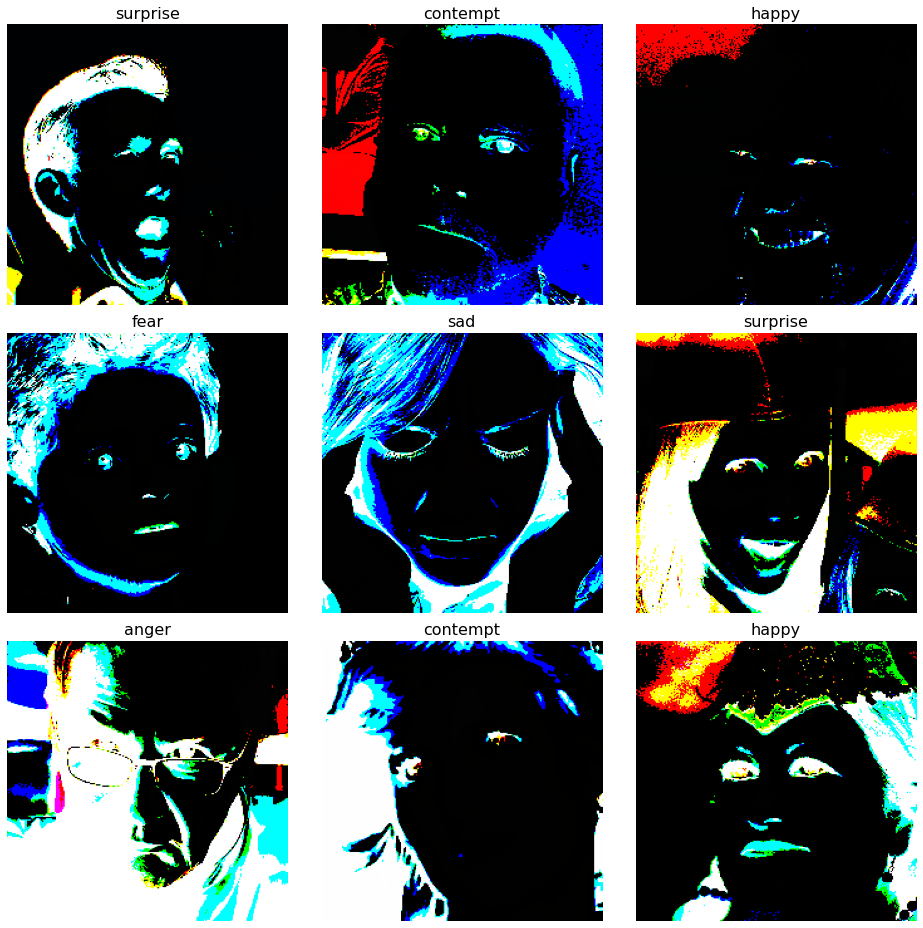

In [97]:
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow((image * 255).astype(np.uint8))
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{Classes[prediction_idx]} [correct]', 'black'
    else:
        return f'{Classes[prediction_idx]} [incorrect, should be {Classes[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

display_nine_images(image, labels)

In [98]:
image_title(labels, predictions)

('fear [incorrect, should be anger]', 'red')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


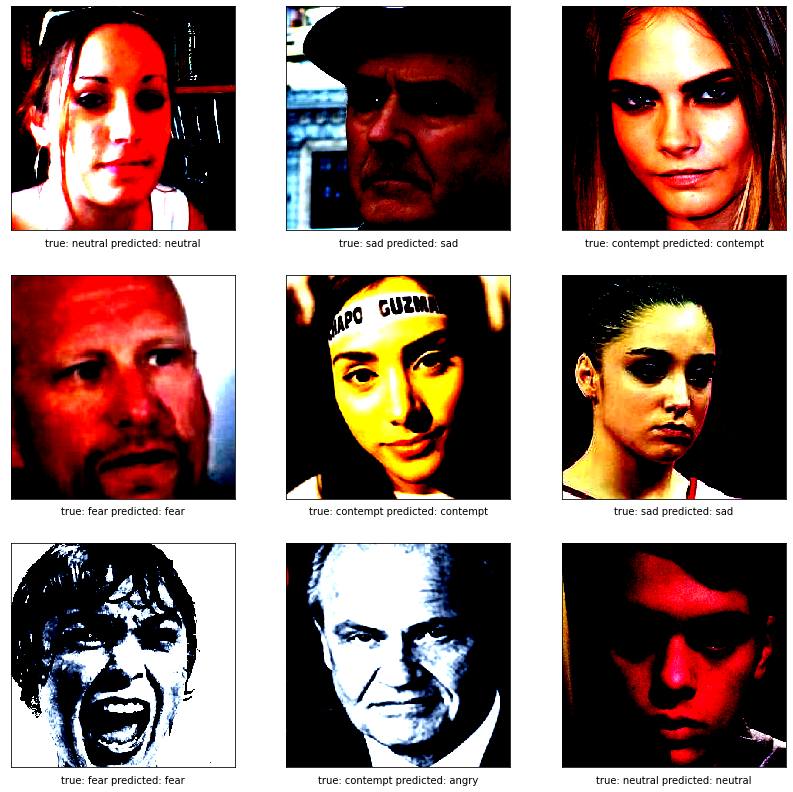

In [134]:
plt.figure(figsize=(14, 14))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((image[i]* (255)))
    plt.xlabel(f'true: {labels[i]} predicted: {predictions_label[i]}')
plt.show()

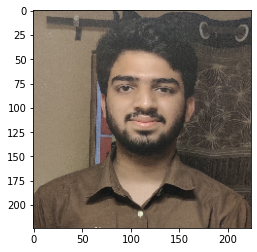

In [135]:
testing_image = os.path.join('sample', 'Mohit.jpg')
img = cv2.imread(testing_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

In [136]:
#img.shape
img = np.expand_dims(img, axis = 0)
#img[np.newaxis, :]
img.shape

(1, 224, 224, 3)

In [138]:
single_prediction = mobileNet_model.predict(img)

1/1 [==============================] - 0s 468ms/step


In [139]:
single_label = np.argmax(single_prediction, axis = -1)
Classes[single_label[0]]

'neutral'

In [25]:
single_label

array([4], dtype=int64)

1/1 [==============================] - 0s 28ms/step


'happy'

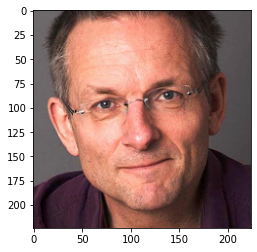

In [140]:
test_img = os.path.join('dataset', 'images', 'val_class', 'class002', 'image0000030.jpg')

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img , (224,224))
plt.imshow(img)

img = np.expand_dims(img, axis = 0)

prediction = efficient_model.predict(img)

single_label = np.argmax(prediction, axis = -1)

Classes[single_label[0]]

In [141]:
def f(X):
    tmp = X.copy()
    #preprocess_input(tmp)
    return mobileNet_model(tmp)

In [142]:
masker = shap.maskers.Image("inpaint_telea", img[0].shape)

In [143]:
explainer = shap.Explainer(f, masker, ouput_names = Classes)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:10, 10.06s/it]                                                                            
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


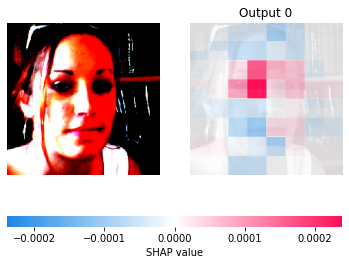

In [144]:
shap_values = explainer(image[:1] * 255, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

In [95]:
print(img.shape)
print(image[0].shape)

(1, 224, 224, 3)
(224, 224, 3)


In [87]:
from lime import lime_image
explainer_lime = lime_image.LimeImageExplainer()

In [145]:
explanation = explainer_lime.explain_instance(image[0].astype('double'), mobileNet_model.predict, top_labels=8, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


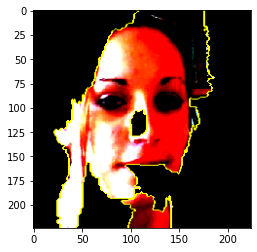

In [146]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=8, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask) * (255))

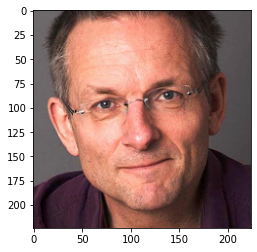

In [91]:
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


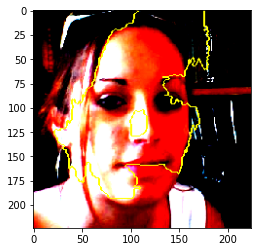

In [147]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask) * (255))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


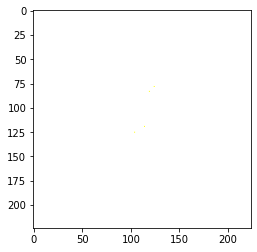

In [307]:
plt.imshow(temp)

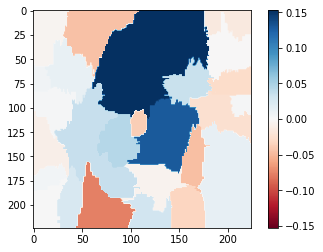

In [148]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [364]:
explanation.top_labels

[3, 6, 5, 4, 2, 1, 0]

In [275]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

KeyError: 'Label not in explanation'